In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [4]:
Reviews = pd.read_csv('Reviews.csv')

In [5]:
Reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
Reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
Reviews.shape

(568454, 10)

In [8]:
Reviews.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


- We have Null values in ProfileName and Summary column
- Number of rows are 568454

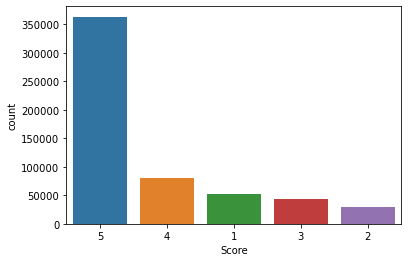

In [9]:
sns.countplot(x=Reviews["Score"],  data=Reviews, order = Reviews["Score"].value_counts().index )

In [10]:
Reviews['ProductId'].value_counts()

B007JFMH8M    913
B002QWHJOU    632
B0026RQTGE    632
B002QWP89S    632
B002QWP8H0    632
             ... 
B002PJ24NU      1
B0078DS4YG      1
B0048IC96I      1
B005EMQAN0      1
B007HP6GN6      1
Name: ProductId, Length: 74258, dtype: int64

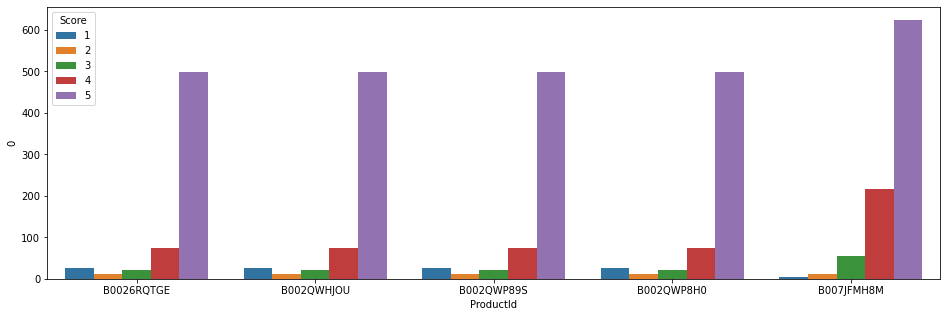

In [11]:
df = Reviews[Reviews['ProductId'].isin(['B007JFMH8M', 'B0026RQTGE','B002QWP89S',
                                  'B002QWHJOU','B002QWP8H0'])].groupby(['ProductId','Score']).size().reset_index()
plt.figure(figsize=(16,5))
sns.barplot(x='ProductId',  data=df, y = 0 , hue = 'Score' )

- Above bargraph shows the products with highest reviews, most of them are high rated

In [12]:
Reviews['Date'] = Reviews['Time'].apply(lambda x :datetime.fromtimestamp(x))
Reviews['weekDay_Time'] = Reviews.Date.dt.weekday
Reviews['month'] = Reviews.Date.dt.month
Reviews['quarter'] = Reviews.Date.dt.quarter

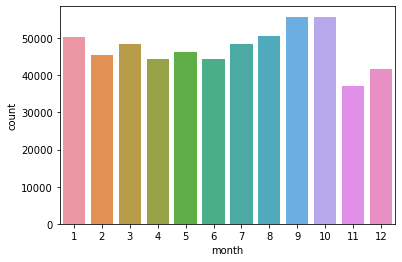

In [13]:
sns.countplot(data=Reviews, x='month')

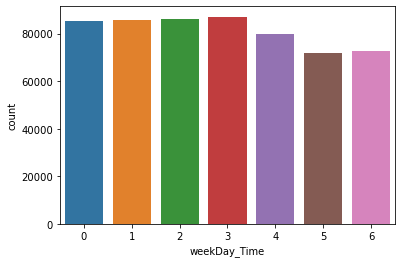

In [14]:
sns.countplot(data=Reviews, x='weekDay_Time')

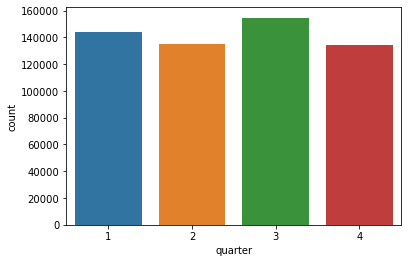

In [15]:
sns.countplot(data=Reviews, x='quarter')

Some basic stats on time of review

Lets process the text and extract some features from the text

In [16]:
Rating = Reviews[['Score', 'Text']]

In [17]:
Rating = Rating.drop_duplicates('Text')
Rating = Rating.reset_index(drop=True)

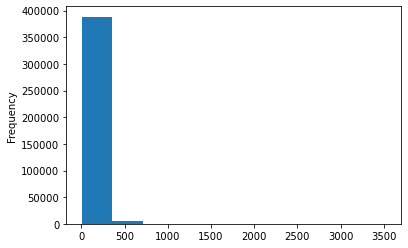

In [18]:
Rating['Text'].apply(lambda x:len(x.split(' '))).plot(kind='hist')

- Most of reviews are of length less than 250 to 300, these text reviews mostly follow power law distribution

In [19]:
import re

In [20]:
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

In [21]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [22]:
Rating['Text'] = Rating['Text'].apply(lambda text: remove_stopwords(text))
Rating.head()

,Score,Text
0,5,I bought several Vitality canned dog food prod...
1,1,Product arrived labeled Jumbo Salted Peanuts.....
2,4,"This confection around centuries. It light, pi..."
3,2,If looking secret ingredient Robitussin I beli...
4,5,Great taffy great price. There wide assortment...


In [23]:
Rating['Text'] = Rating['Text'].apply(lambda text: remove_urls(text))
Rating.head()

,Score,Text
0,5,I bought several Vitality canned dog food prod...
1,1,Product arrived labeled Jumbo Salted Peanuts.....
2,4,"This confection around centuries. It light, pi..."
3,2,If looking secret ingredient Robitussin I beli...
4,5,Great taffy great price. There wide assortment...


In [24]:
Rating['Text'] = Rating['Text'].apply(lambda text: text.lower())
Rating.head()

,Score,Text
0,5,i bought several vitality canned dog food prod...
1,1,product arrived labeled jumbo salted peanuts.....
2,4,"this confection around centuries. it light, pi..."
3,2,if looking secret ingredient robitussin i beli...
4,5,great taffy great price. there wide assortment...


In [26]:
review_list =[]
for index, rows in Rating.iterrows():
    review_list.append(Rating['Text'].iloc[index])

In [27]:
tfv = TfidfVectorizer(min_df=10,  max_features=100, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3),
            stop_words = 'english')

tfv.fit(review_list)

TfidfVectorizer(max_features=100, min_df=10, ngram_range=(1, 3),
                stop_words='english', strip_accents='unicode')

In [28]:
review_transformed = []
for row in review_list:
    review_transformed.append(tfv.transform([row]))

In [29]:
review_vec = []
for row in review_transformed:
    review_vec.append(row.toarray()[0].tolist())
#     break

In [30]:
review_df = pd.DataFrame(review_vec)

In [31]:
review_df['Score'] = Rating['Score']

- We will train RandomForest, Logistic Regression and KNN algorithm for rating predictions

In [32]:
def train_model(dataframe):
    xtrain, xtest, ytrain, ytest = train_test_split(dataframe.iloc[:,:-1], dataframe.iloc[:,-1], 
                                                    test_size=0.2, random_state=42)
    
    lr = LogisticRegression()   
    
    lr.fit(xtrain, ytrain)
    ytrain_pred = lr.predict(xtrain)
    ytest_pred = lr.predict(xtest)
    print('Logistic Regression Train  Confusion Matrix - \n' + str(confusion_matrix(ytrain , ytrain_pred)))
    print('Logistic Regression Test  Confusion Matrix - \n' + str(confusion_matrix(ytest , ytest_pred)))
    print('Logistic Regression Train Report - \n' + str(classification_report(ytrain , ytrain_pred)))
    print('Logistic Regression Test Report - \n' + str(classification_report(ytest , ytest_pred)))
    print('-------------------------------------------------------------------- \n')
    
    mnb = MultinomialNB()
    mnb.fit(xtrain, ytrain)
    ytrain_pred = mnb.predict(xtrain)
    ytest_pred = mnb.predict(xtest)
    print('MultinomialNB Train  Confusion Matrix - \n' + str(confusion_matrix(ytrain , ytrain_pred)))
    print('MultinomialNB Test  Confusion Matrix - \n' + str(confusion_matrix(ytest , ytest_pred)))
    print('MultinomialNB Train Report - \n' + str(classification_report(ytrain , ytrain_pred)))
    print('MultinomialNB Test Report - \n' + str(classification_report(ytest , ytest_pred)))
    print('-------------------------------------------------------------------- \n')
    
    
    rf = RandomForestClassifier()
    rf.fit(xtrain, ytrain)
    ytrain_pred = rf.predict(xtrain)
    ytest_pred = rf.predict(xtest)
    print('Random Forest Train Confusion Matrix - \n' + str(confusion_matrix(ytrain , ytrain_pred)))
    print('Random Forest Test Confusion Matrix - \n' + str(confusion_matrix(ytest , ytest_pred)))
    print('Random Forest Train Report - \n' + str(classification_report(ytrain , ytrain_pred)))
    print('Random Forest Test Report - \n' + str(classification_report(ytest , ytest_pred)))    
    print('-------------------------------------------------------------------- \n')

In [33]:
train_model(review_df)

Logistic Regression Train  Confusion Matrix - 
[[  5897     68    266    117  22652]
 [  2088     73    320    205  14021]
 [  1815     45    614    689  20701]
 [  1365     21    493   1271  41751]
 [  3958     45    394   1008 194986]]
Logistic Regression Test  Confusion Matrix - 
[[ 1493    21    73    26  5662]
 [  524    12    88    59  3402]
 [  453    13   184   190  5050]
 [  343     5   111   329 10353]
 [ 1045    10    98   225 48947]]
Logistic Regression Train Report - 
              precision    recall  f1-score   support

           1       0.39      0.20      0.27     29000
           2       0.29      0.00      0.01     16707
           3       0.29      0.03      0.05     23864
           4       0.39      0.03      0.05     44901
           5       0.66      0.97      0.79    200391

    accuracy                           0.64    314863
   macro avg       0.40      0.25      0.23    314863
weighted avg       0.55      0.64      0.54    314863

Logistic Regression Test 

- Logistic Regression and MultinomialNB has very bad results.
- RandomForest is getting overfit, lets try tuning the models

Instead of using Tf-IDF, now we will use bag of words for converting text into  vectors

In [57]:
countVec = CountVectorizer(min_df=10,  max_features=100, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3),
            stop_words = 'english')

countVec.fit(review_list)

CountVectorizer(max_features=100, min_df=10, ngram_range=(1, 3),
                stop_words='english', strip_accents='unicode')

In [58]:
review_transformed = []
for row in review_list:
    review_transformed.append(countVec.transform([row]))

In [59]:
review_vec = []
for row in review_transformed:
    review_vec.append(row.toarray()[0].tolist())
#     break

In [60]:
review_df = pd.DataFrame(review_vec)

In [61]:
review_df['Score'] = Rating['Score']

In [62]:
train_model(review_df)

Logistic Regression Train  Confusion Matrix - 
[[  4784    136    349    191  23540]
 [  1905    153    467    350  13832]
 [  1633    181    905   1079  20066]
 [  1159     95    836   2267  40544]
 [  2501    148    635   1993 195114]]
Logistic Regression Test  Confusion Matrix - 
[[ 1233    44    94    42  5862]
 [  456    28   128    92  3381]
 [  417    32   248   297  4896]
 [  275    26   192   567 10081]
 [  655    40   201   501 48928]]
Logistic Regression Train Report - 
              precision    recall  f1-score   support

           1       0.40      0.16      0.23     29000
           2       0.21      0.01      0.02     16707
           3       0.28      0.04      0.07     23864
           4       0.39      0.05      0.09     44901
           5       0.67      0.97      0.79    200391

    accuracy                           0.65    314863
   macro avg       0.39      0.25      0.24    314863
weighted avg       0.55      0.65      0.54    314863

Logistic Regression Test 

- Results are same as TF-IDF, RandomForest is getting overfit.
- Logistic Regression and Navie Bayers are not performing properly

# Lets trying classifying the test using BERT Transformers

I have tried training model using BERT pretrained model, but the model is taking 6 hours even for one epoch, I have stopped the training. This can be taken later

In [68]:
# from tensorflow.keras.utils import to_categorical

In [69]:
# 314863*.30

In [70]:
# Rating_sample = Rating.sample(20000, random_state= 42)

In [71]:
# xtrain, xtest, ytrain, ytest = train_test_split(Rating_sample['Text'], Rating_sample['Score'], 
#                                                     test_size=0.2, random_state=42)

In [72]:
# xtrain.shape

In [73]:
# y_train = to_categorical(ytrain)
# y_test = to_categorical(ytest)

In [74]:
# !pip install transformers
# import transformers

In [76]:
# from transformers import AutoTokenizer,TFBertModel
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [52]:
# xtrain_ = []
# for index, rows in xtrain.iteritems():
#     xtrain_.append(xtrain[index])

In [53]:
# xtest_ = []
# for index, rows in xtest.iteritems():
#     xtest_.append(xtest[index])

In [54]:
# x_train = tokenizer(
#     text=xtrain_,
#     add_special_tokens=True,
#     max_length=70,
#     truncation=True,
#     padding=True, 
#     return_tensors='tf',
#     return_token_type_ids = False,
#     return_attention_mask = True,
#     verbose = True)

In [55]:
# x_test = tokenizer(
#     text=xtest_,
#     add_special_tokens=True,
#     max_length=70,
#     truncation=True,
#     padding=True, 
#     return_tensors='tf',
#     return_token_type_ids = False,
#     return_attention_mask = True,
#     verbose = True)

In [56]:
# input_ids = x_train['input_ids']
# attention_mask = x_train['attention_mask']

In [62]:
# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.initializers import TruncatedNormal
# from tensorflow.keras.losses import CategoricalCrossentropy
# from tensorflow.keras.metrics import CategoricalAccuracy
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import Input, Dense
# import torch

In [58]:
# max_len = 70
# input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
# input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = bert(input_ids,attention_mask = input_mask)[0] 
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# out = Dense(128, activation='relu')(out)
# out = tf.keras.layers.Dropout(0.1)(out)
# out = Dense(32,activation = 'relu')(out)
# y = Dense(6,activation = 'sigmoid')(out)
# model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
# model.layers[2].trainable = True


In [59]:
# optimizer = Adam(
#     learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
#     epsilon=1e-08,
#     decay=0.01,
#     clipnorm=1.0)
# loss =CategoricalCrossentropy(from_logits = True)
# metric = CategoricalAccuracy('balanced_accuracy'),
# model.compile(
#     optimizer = optimizer,
#     loss = loss, 
#     metrics = metric)

In [63]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [60]:
# train_history = model.fit(
#     x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
#     y = y_train,
#     validation_data = (
#     {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
#     ),
#   epochs=1,
#     batch_size=36
# )

  7/445 [..............................] - ETA: 3:00:27 - loss: 1.2624 - balanced_accuracy: 0.6389

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\wahee\anaconda3\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-f35a204c68e7>", line 8, in <module>
    batch_size=36
  File "C:\Users\wahee\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\wahee\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\wahee\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\wahee\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\eager\function.py", line 3040, in __call__
    filtered_flat_args, captured_inputs=graph

KeyboardInterrupt: 

In [ ]:
# predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [ ]:
# y_predicted = np.argmax(predicted_raw, axis = 1)

In [ ]:
# print(classification_report(y_true, y_predicted))